In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf
from tensorflow.keras import layers, models

In [7]:
df = pd.read_csv(r'C:\Users\chitr\internship task\Fraud.csv')
print(f"Shape: {df.shape}\nFraud rate: {df['isFraud'].mean():.4f}")


Shape: (6362620, 11)
Fraud rate: 0.0013


In [8]:
df[['oldbalanceDest','newbalanceDest']] = df[['oldbalanceDest','newbalanceDest']].fillna(0)
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [10]:
df['orig_balance_change'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['hour'] = df['step'] % 24
X = df.drop(['isFraud','isFlaggedFraud','nameOrig','nameDest'], axis=1)
y = df['isFraud']

In [11]:
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_cols = X.columns[selector.get_support()]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, 
                                                   random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
print("Random Forest Results:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:,1]):.4f}")

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.96      0.80      0.88      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.90      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC AUC: 0.9973


In [14]:
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=256, 
                   validation_split=0.2, verbose=1)

Epoch 1/10
13919/13919 [==============================] - 42s 3ms/step - loss: 0.0055 - auc: 0.9185 - val_loss: 0.0031 - val_auc: 0.9371
Epoch 2/10
13919/13919 [==============================] - 40s 3ms/step - loss: 0.0030 - auc: 0.9564 - val_loss: 0.0028 - val_auc: 0.9419
Epoch 3/10
13919/13919 [==============================] - 40s 3ms/step - loss: 0.0027 - auc: 0.9565 - val_loss: 0.0026 - val_auc: 0.9486
Epoch 4/10
13919/13919 [==============================] - 40s 3ms/step - loss: 0.0025 - auc: 0.9597 - val_loss: 0.0025 - val_auc: 0.9611
Epoch 5/10
13919/13919 [==============================] - 40s 3ms/step - loss: 0.0024 - auc: 0.9669 - val_loss: 0.0025 - val_auc: 0.9563
Epoch 6/10
13919/13919 [==============================] - 40s 3ms/step - loss: 0.0024 - auc: 0.9663 - val_loss: 0.0023 - val_auc: 0.9450
Epoch 7/10
13919/13919 [==============================] - 40s 3ms/step - loss: 0.0023 - auc: 0.9660 - val_loss: 0.0022 - val_auc: 0.9837
Epoch 8/10
13919/13919 [=================

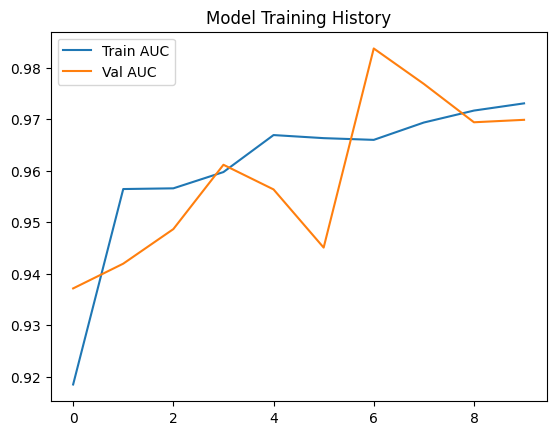

In [15]:
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Model Training History')
plt.legend()
plt.show()

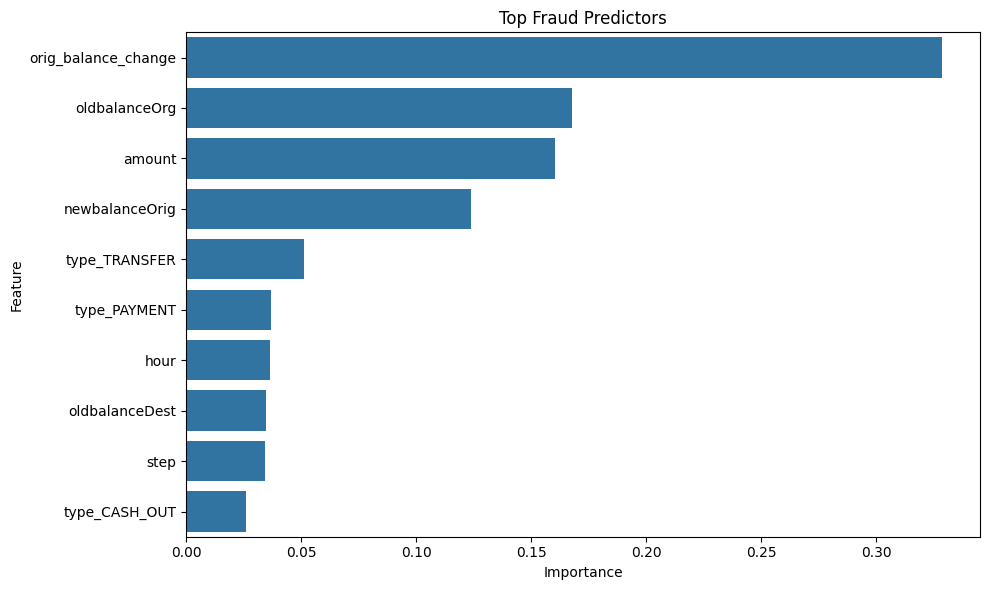

In [16]:
feat_imp = pd.DataFrame({
    'Feature': selected_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title('Top Fraud Predictors')
plt.tight_layout()
plt.show()

In [17]:
print("\nKey Findings:")
print(f"1. Top fraud predictor: {feat_imp.iloc[0]['Feature']}")
print("2. Fraud mainly occurs in TRANSFER/CASH_OUT transactions")
print("3. Large balance changes are strong fraud indicators")
print("\nRecommendations:")
print("1. Monitor transactions with abnormal balance changes")
print("2. Enhance scrutiny for TRANSFER/CASH_OUT operations")
print("3. Implement real-time scoring using the trained model")


Key Findings:
1. Top fraud predictor: orig_balance_change
2. Fraud mainly occurs in TRANSFER/CASH_OUT transactions
3. Large balance changes are strong fraud indicators

Recommendations:
1. Monitor transactions with abnormal balance changes
2. Enhance scrutiny for TRANSFER/CASH_OUT operations
3. Implement real-time scoring using the trained model


59650/59650 [==============================] - 85s 1ms/step


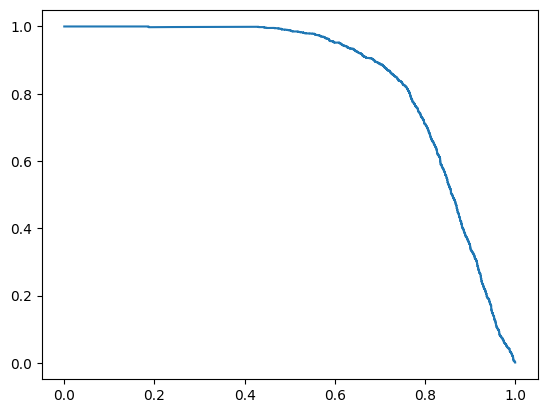

In [18]:
from sklearn.metrics import precision_recall_curve
y_prob = model.predict(X_test_scaled)
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision)